In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from datasets import Dataset, NetflixData, NetflixGenreData
X_data = NetflixData(small=True)
Z_data = NetflixGenreData(small=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# down-sampling by constraints

sum_u, sum_v = X_data.X.sum

# idx_u = sum_u > 130
# idx_v = sum_v > 200

idx_u = sum_u > 40
idx_v = sum_v > 60

print("original shape:", X_data.X.shape)
print("filtered shape:", (sum(idx_u), sum(idx_v)))

X_data.sample(idx=idx_u, axis=0)
print("filtered shape:", X_data.X.shape)
X_data.sample(idx=idx_v, axis=1)
print("filtered shape:", X_data.X.shape)
Z_data.sample(idx=idx_v, axis=1)
print("filtered shape:", Z_data.X.shape)

original shape: (9980, 3362)
filtered shape: (3690, 1069)
[I] sampling with given indices
filtered shape: (3690, 3362)
[I] sampling with given indices
filtered shape: (3690, 1069)
[I] sampling with given indices
filtered shape: (22, 1069)


In [5]:
# down-sampling by random

X_data.sample(n=1000, axis=0)
print(X_data.X.shape)
idx_v = X_data.sample(n=500, axis=1)
print(X_data.X.shape)
Z_data.sample(idx=idx_v, axis=1)
print(Z_data.X.shape)

[I] sampling to size 1000
[I]   Data seed    : 1701404893
(1000, 1069)
[I] sampling to size 500
(1000, 500)
[I] sampling with given indices
(22, 500)


[I] Summary of X(1000, 500):
[I]   row/col mean (107.8, 53.9), row/col median (56.0, 42.0)


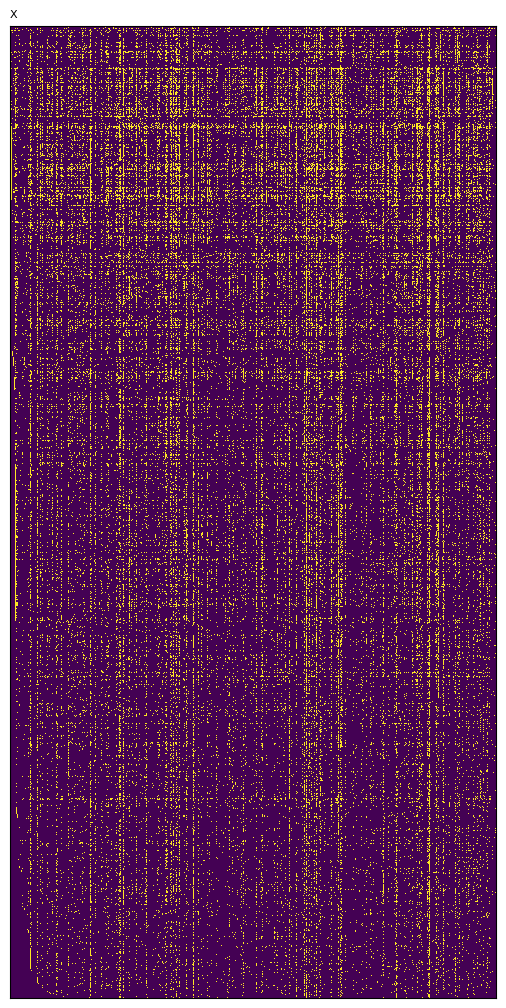

[I] Summary of X(22, 500):
[I]   row/col mean (2.9, 66.2), row/col median (3.0, 39.5)


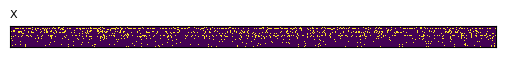

In [10]:
X_data.no_split()

Z_data.no_split()
Z_data.X.update(name='X')
Z_data.U.update(name='U')
Z_data.V.update(name='V')

X_dataset = Dataset()
X_dataset.load_data(X=X_data.train_data, U=X_data.U, V=X_data.V)
X_dataset.summarize(display=True, pixels=2, ordered=True)

Z_dataset = Dataset()
Z_dataset.load_data(X=Z_data.train_data, U=Z_data.U, V=Z_data.V)
Z_dataset.summarize(display=True, pixels=2, ordered=True)

[I] k            : 5
[I] tau          : 0.2
[I] weights      : [0.7, 0.3]
[I] k            : 5
[I] tau          : 0.2
[I] weights      : [0.7, 0.3]
[I] display : True
[W] Missing validation set.


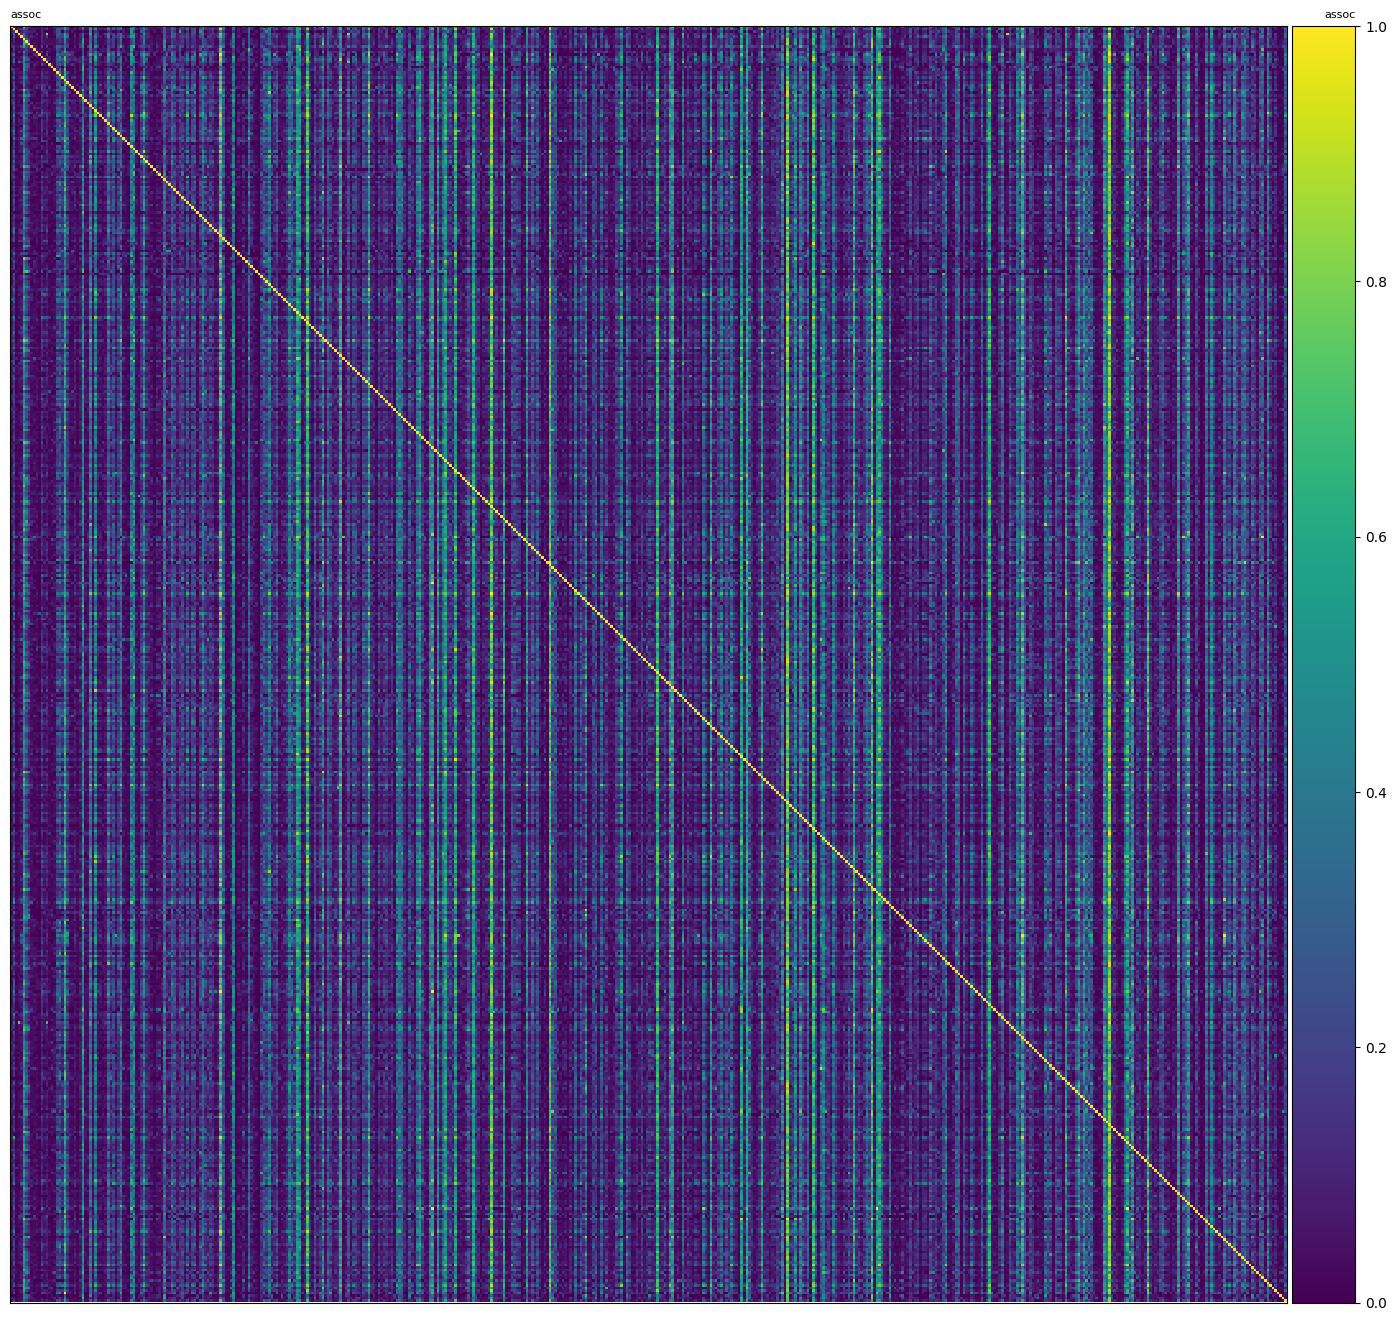

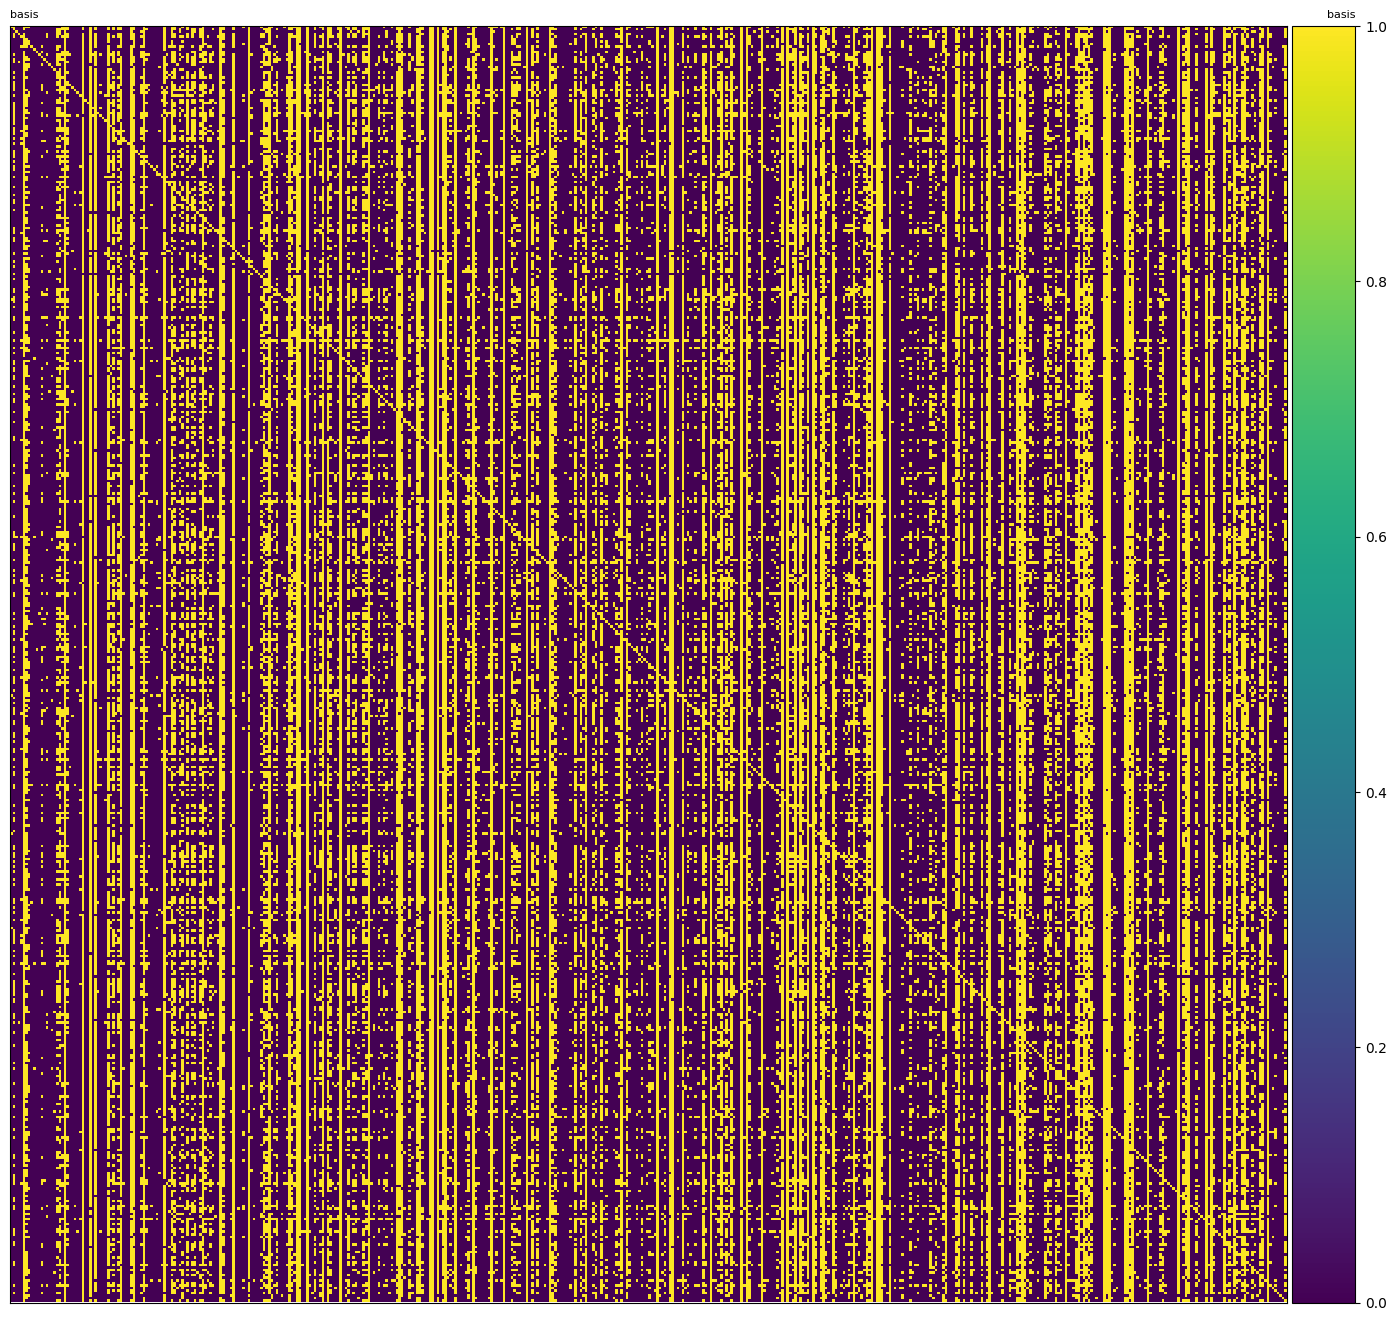

[I] display : False
[W] Missing validation set.


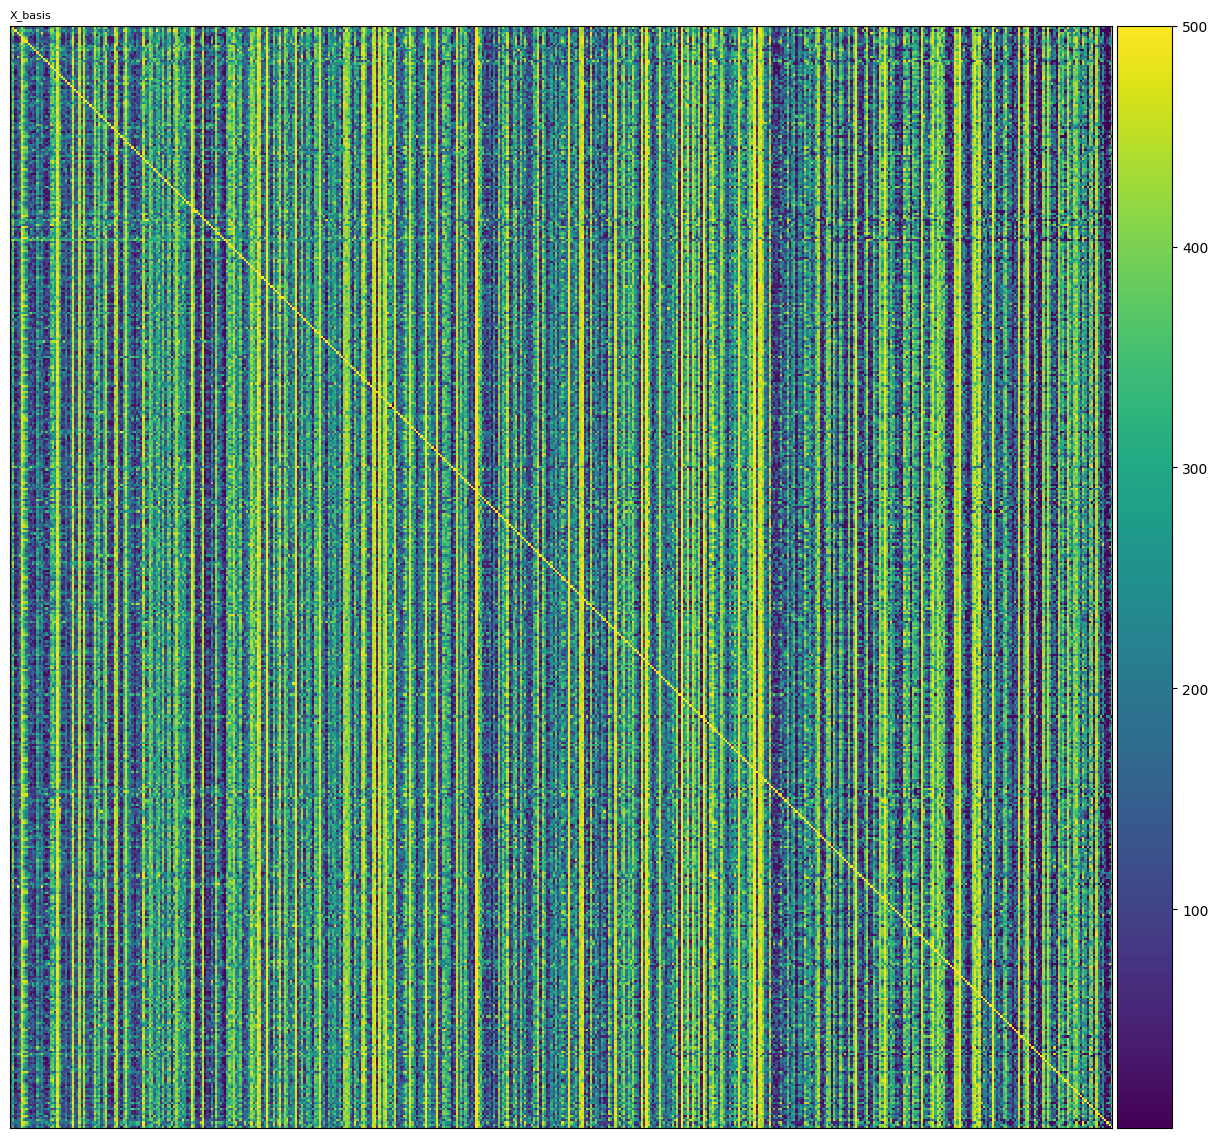

[I] display : True
[W] Missing validation set.


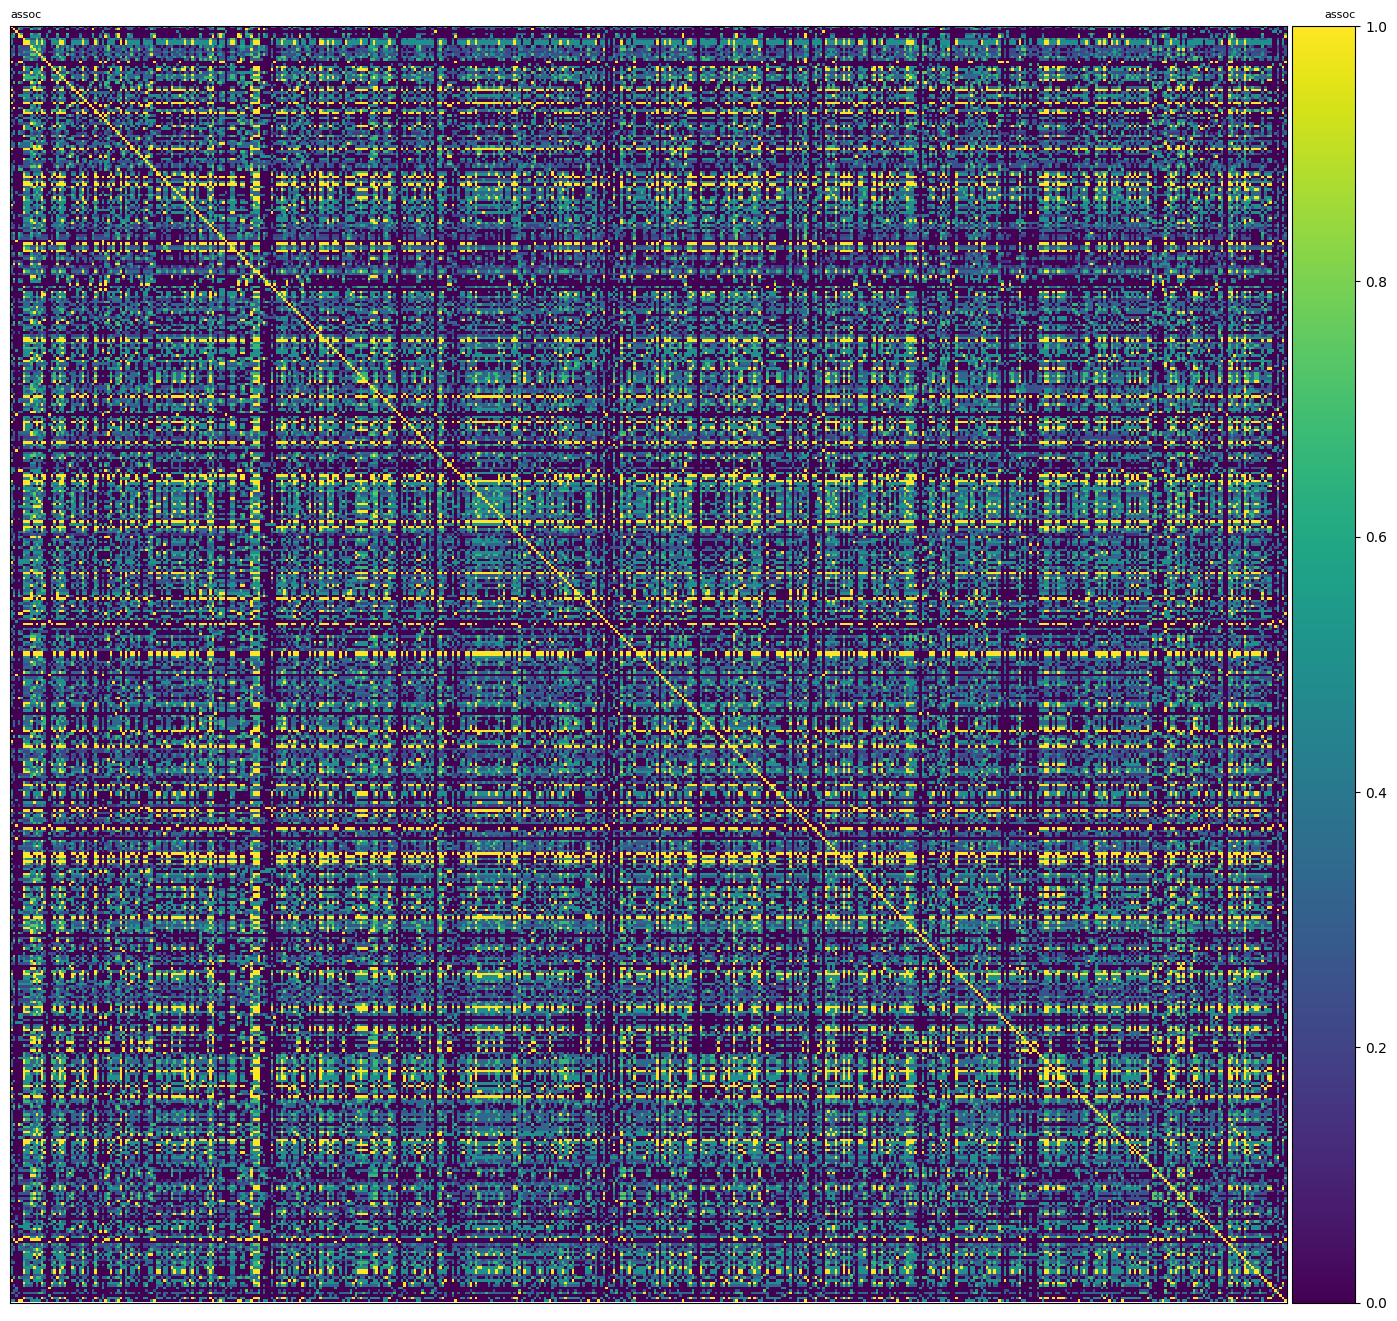

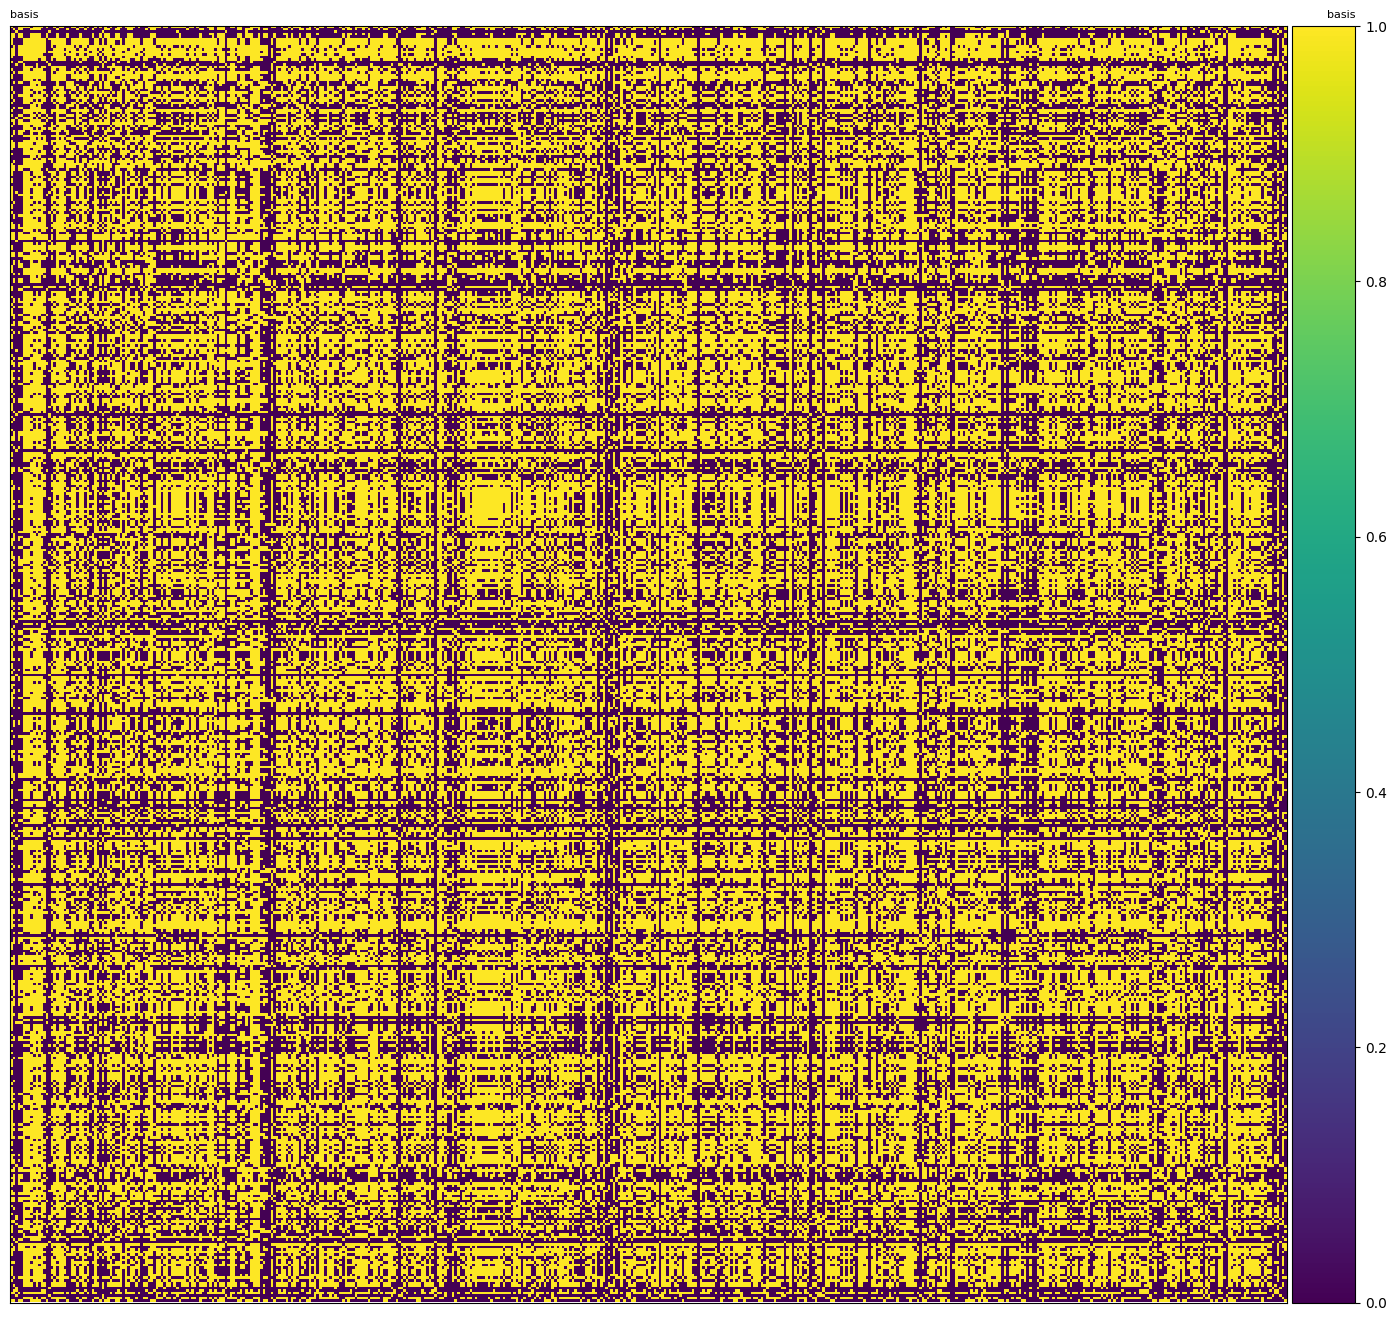

[I] display : False
[W] Missing validation set.


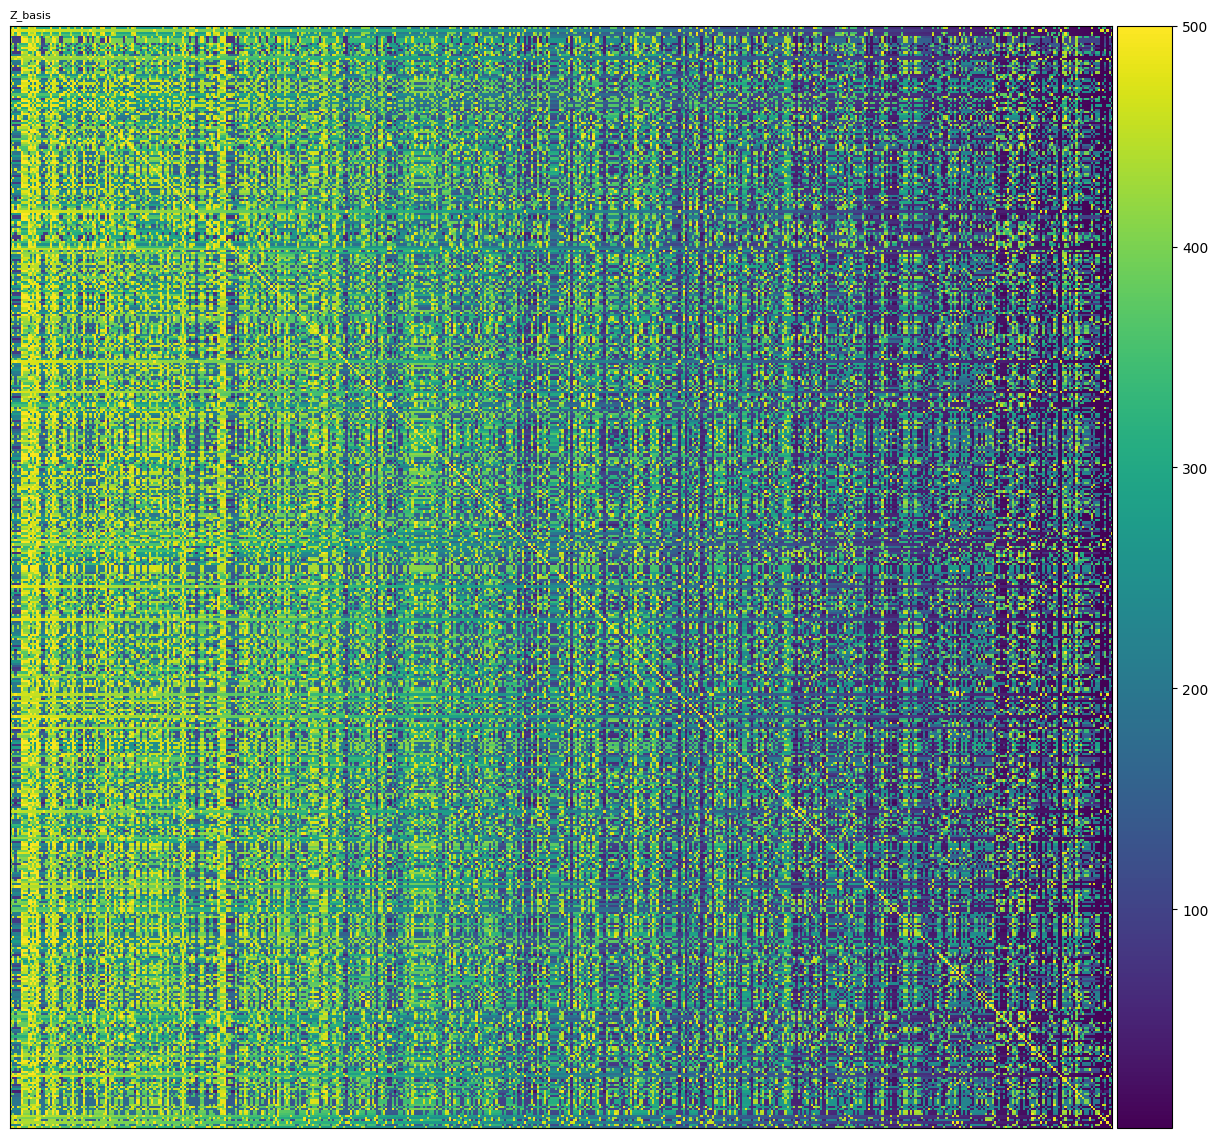

In [11]:
from models import Asso, AssoQuant
from utils import show_matrix, check_sparse

k = 5
tau = 0.20
w = [0.7, 0.3]

n_col = 500

asso = Asso(k=k, tau=tau, w=w)
aq = AssoQuant(k=k, tau=tau, w=w)

asso._fit_prepare(train_set=X_dataset, display=True)
X_assoc = check_sparse(asso.assoc, sparse=False)
X_basis_asso = check_sparse(asso.basis, sparse=False)
# settings = [(X_basis, [0, 0], 'X_basis ASSO')]
# show_matrix(settings=settings, colorbar=True)

aq._fit_prepare(train_set=X_dataset, display=False)
X_basis = aq.basis
settings = [(n_col - aq.basis + 1, [0, 0], 'X_basis')]
show_matrix(settings=settings, colorbar=True)

#

asso._fit_prepare(train_set=Z_dataset, display=True)
Z_assoc = check_sparse(asso.assoc, sparse=False)
Z_basis_asso = check_sparse(asso.basis, sparse=False)
# settings = [(Z_basis, [0, 0], 'Z_basis ASSO')]
# show_matrix(settings=settings, colorbar=True)

aq._fit_prepare(train_set=Z_dataset, display=False)
Z_basis = aq.basis
settings = [(n_col - aq.basis + 1, [0, 0], 'Z_basis')]
show_matrix(settings=settings, colorbar=True)

In [24]:
from utils import dot
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

# plt.rcParams["figure.figsize"] = [10.00, 10.00]
# plt.figure(dpi=1200)

def overlap(i, j):
    '''overlap of i-th row in X with j-th row in Z
    '''
    # x = (X_basis[i]<=t) * 1
    # z = (Z_basis[j]<=t) * 1
    # return dot(x, z)

    # len(Z_basis[j, X_basis[i]<=t] <= t)

    score = np.zeros(n_col)

    for t in range(n_col):
        X_row = X_basis[i]
        Z_row = Z_basis[j]
        score[t] = sum(Z_row[X_row<=(t+1)]<=(t+1))
        score[t] = score[t] / (t+1)
        score[t] = score[t] * X_assoc[i, X_row==(t+1)] * Z_assoc[i, Z_row==(t+1)]
    return score

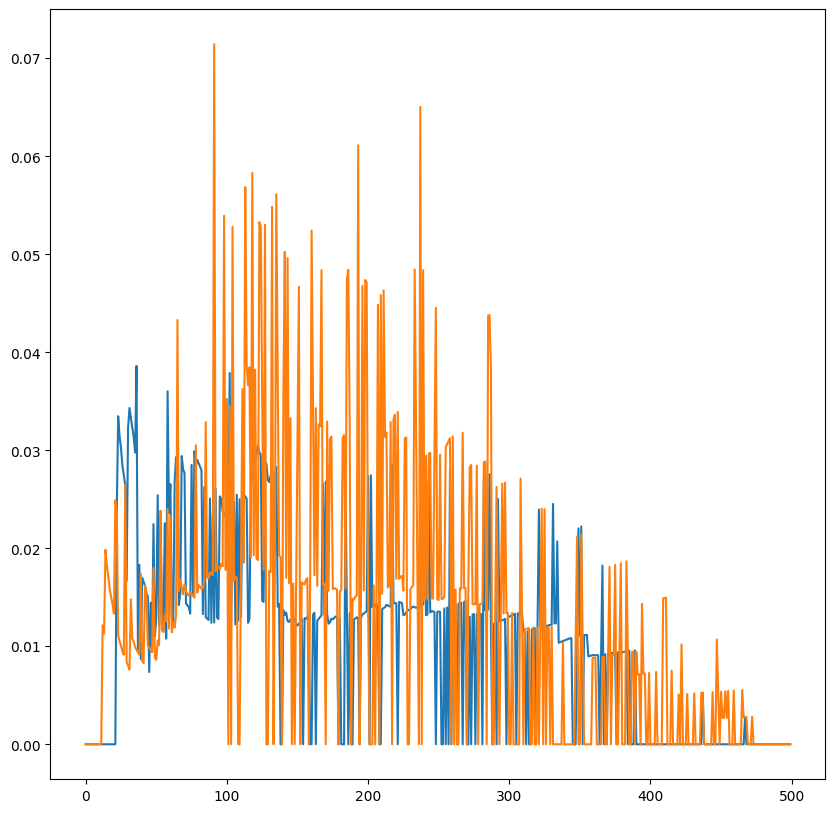

In [25]:
# inconsistant
i = 250 # i-th basis from X_basis
j = 350 # j-th basis from Z_basis

covers = overlap(i, j)
plt.plot(np.arange(n_col), covers);

# inconsistant
i = 250 # i-th basis from X_basis
j = 300 # j-th basis from Z_basis

covers = overlap(i, j)
plt.plot(np.arange(n_col), covers);

In [16]:
# all
import matplotlib.pylab as pl

plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.figure(dpi=1200)

colors = pl.cm.hot(np.linspace(0, 1, n_col))

covers = np.zeros((n_col, n_col))
for j in tqdm(range(n_col)):
    covers[:, j] = overlap(i, j)



100%|██████████| 500/500 [00:09<00:00, 55.17it/s]


100%|██████████| 500/500 [00:00<00:00, 8842.44it/s]


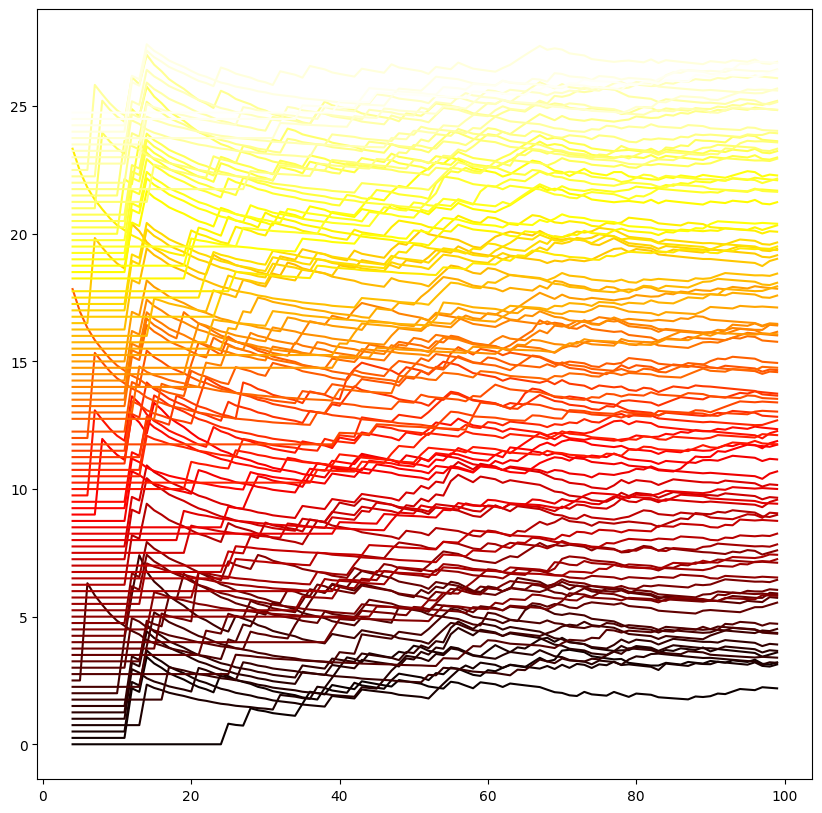

In [22]:
for j in tqdm(range(n_col)):
    if j % 5 == 0:
        pl.plot(np.arange(4, 100),  40 * covers[4:100, j] + 0.05 * j, color=colors[j])